In [1]:
import numpy as np
import sympy as sm
from scipy import optimize
from scipy.optimize import minimize
import statistics as stat

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [3]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [4]:
#Choose the amount of observations
N=10000

#Define the transposed y-matrix
YT = np.array([y])
#Transpose it to make it vertical
Y = YT.T

#Make the X-matrix
X = np.column_stack((np.ones(N),x1,x2))

#Transpose X-matrix
XT = X.T


In [5]:
#Calculating beta_hat
beta_hat = np.linalg.inv(XT@X)@XT@Y

#Define each estimate
beta_hat0 = beta_hat[0,0]
beta_hat1 = beta_hat[1,0]
beta_hat2 = beta_hat[2,0]

print(f'With matrix algebra: beta_hat0 = {beta_hat0:.4f}, beta_hat1 = {beta_hat1:.4f}, beta_hat2 = {beta_hat2:.4f}')

With matrix algebra: beta_hat0 = 0.0957, beta_hat1 = 0.2929, beta_hat2 = 0.5033


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

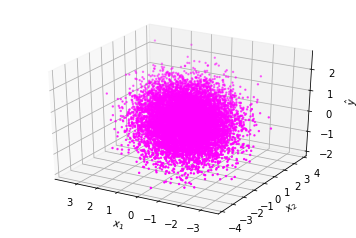

In [6]:
#We find the estimated value of y
yhat = beta_hat0 + beta_hat1*x1 + beta_hat2*x2

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x1,x2,yhat,s=2,c='magenta')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\hat{y}$')

ax.invert_xaxis()

plt.show()

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [7]:
ols=np.linalg.lstsq(X, Y, rcond=None)[0]
print(f'With numerical solver: beta_hat0 = {ols[0,0]:.4f}, beta_hat1 = {ols[1,0]:.4f}, beta_hat2 = {ols[2,0]:.4f}')

With numerical solver: beta_hat0 = 0.0957, beta_hat1 = 0.2929, beta_hat2 = 0.5033


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [8]:
def lad_func(b,x1,x2,y):
    """
    Args:
    b (array)  : An array containing our beta parameters
    x1 (array) : Array containing our x1-values
    x2 (array) : Array containing our x2-values
    y (array)  : Array containing our y-values
    """
    beta0 = b[0]
    beta1 = b[1]
    beta2 = b[2]
    return np.sum(np.abs(y-(beta0+beta1*x1+beta2*x2)))
    
output = minimize(lad_func,ols,args=(x1,x2,y))

print(f'With LAD: beta_hat0 = {output.x[0]:.4f}, beta_hat1 = {output.x[1]:.4f}, beta_hat2 = {output.x[2]:.4f}')

With LAD: beta_hat0 = 0.0922, beta_hat1 = 0.3074, beta_hat2 = 0.5115


**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [9]:
N=50

beta_0_lad = []
beta_1_lad = []
beta_2_lad = []
    
for K in range(5000):
    
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    eps = np.random.normal(0,1,size=N)
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    def lad_func(b,x1,x2,y):
        beta0 = b[0]
        beta1 = b[1]
        beta2 = b[2]
        return np.sum(np.abs(y-(beta0+beta1*x1+beta2*x2)))
    
    output = minimize(lad_func,ols,args=(x1,x2,y))

    beta_0_lad.append(output.x[0])
    beta_1_lad.append(output.x[1])
    beta_2_lad.append(output.x[2])


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [10]:
beta_0_ols = []
beta_1_ols = []
beta_2_ols = []

for K in range(5000):
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    eps = np.random.normal(0,1,size=N)
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    #Make the X-matrix
    X = np.column_stack((np.ones(N),x1,x2))

    #Define the transposed y-matrix
    YT = np.array([y])
    #Transpose it to make it vertical
    Y = YT.T
    
    
    ols=np.linalg.lstsq(X, Y, rcond=None)[0]
    
    beta_0_ols.append(ols[0,0])
    beta_1_ols.append(ols[1,0])
    beta_2_ols.append(ols[2,0])

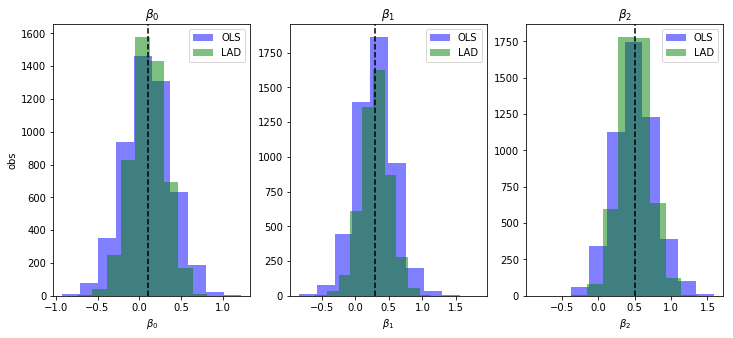

In [11]:
figb0 = plt.figure(figsize=(12,5))
ax_left = figb0.add_subplot(1,3,1)
ax_left.hist(beta_0_ols,alpha=0.5,color='blue',label='OLS')
ax_left.hist(beta_0_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.1,color='black',linestyle='--')
ax_left.set_title(r'$\beta_0$')
ax_left.set_xlabel(r'$\beta_0$')
ax_left.set_ylabel('obs')
ax_left.legend(loc='upper right');

ax_middle = figb0.add_subplot(1,3,2)
ax_middle.hist(beta_1_ols,alpha=0.5,color='blue',label='OLS')
ax_middle.hist(beta_1_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.3,color='black',linestyle='--')
ax_middle.set_title(r'$\beta_1$')
ax_middle.set_xlabel(r'$\beta_1$')
ax_middle.legend(loc='upper right');

ax_right = figb0.add_subplot(1,3,3)
ax_right.hist(beta_2_ols,alpha=0.5,color='blue',label='OLS')
ax_right.hist(beta_2_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.5,color='black',linestyle='--')
ax_right.set_title(r'$\beta_2$')
ax_right.set_xlabel(r'$\beta_2$')
ax_right.legend(loc='upper right');

plt.show()

In [12]:
print(f'Mean of beta_0 using LAD is {stat.mean(beta_0_lad):.4f}, standard deviation is {stat.stdev(beta_0_lad):.4f}')
print(f'Mean of beta_0 using OLS is {stat.mean(beta_0_ols):.4f}, standard deviation is {stat.stdev(beta_0_ols):.4f}')
print(' ')
print(f'Mean of beta_1 using LAD is {stat.mean(beta_1_lad):.4f}, standard deviation is {stat.stdev(beta_1_lad):.4f}')
print(f'Mean of beta_1 using OLS is {stat.mean(beta_1_ols):.4f}, standard deviation is {stat.stdev(beta_1_ols):.4f}')
print(' ')
print(f'Mean of beta_2 using LAD is {stat.mean(beta_2_lad):.4f}, standard deviation is {stat.stdev(beta_2_lad):.4f}')
print(f'Mean of beta_2 using OLS is {stat.mean(beta_2_ols):.4f}, standard deviation is {stat.stdev(beta_2_ols):.4f}')

Mean of beta_0 using LAD is 0.1029, standard deviation is 0.2034
Mean of beta_0 using OLS is 0.0986, standard deviation is 0.2806
 
Mean of beta_1 using LAD is 0.3029, standard deviation is 0.2118
Mean of beta_1 using OLS is 0.3003, standard deviation is 0.2851
 
Mean of beta_2 using LAD is 0.5008, standard deviation is 0.2099
Mean of beta_2 using OLS is 0.5025, standard deviation is 0.2817


Generally, the LAD-estimates have smaller standard deviations. This might be caused by the LAD-method giving less weight to outliers. Overall, it's hard to tell which estimation gives the most accurate results. LAD is generally more preferable if the distribution suffer from high kurtosis and skewness, which does not appear in this case. However, since the standard deviations seem to be smaller and the estimates does not seem to be significantly different from the true values for the LAD-method, we consider this to be preferable.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [ ]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [ ]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [ ]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    pass

**Test case:**

In [ ]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')